In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam

import keras_tuner as kt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Getting Data

In [6]:
train_data_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
train_data_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test_data_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
test_data_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
test_data = test_data_df.to_numpy()
print(f'Type of the test_data container: {type(test_data)}')
print(f'Shape of the test_data array: {test_data.shape}')

Type of the test_data container: <class 'numpy.ndarray'>
Shape of the test_data array: (28000, 784)


# Data Understanding

In [9]:
train_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


## Extract labels

In [10]:
train_data_labels = train_data_df.iloc[:,0].to_numpy()
print(f'Type of the labels container: {type(train_data_labels)}')
print(f'Shape of the labels array: {train_data_labels.shape}')

Type of the labels container: <class 'numpy.ndarray'>
Shape of the labels array: (42000,)


## Extract features

In [11]:
train_data = train_data_df.iloc[:, 1:].to_numpy()
print(f'Type of the features container: {type(train_data)}')
print(f'Shape of the features array: {train_data.shape}')

Type of the features container: <class 'numpy.ndarray'>
Shape of the features array: (42000, 784)


## Display image for better intuition about data

In [12]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis("off")

Digit - 8


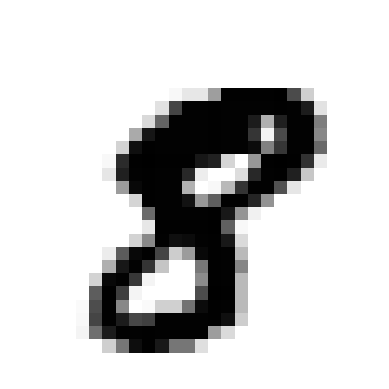

In [13]:
digit = train_data[10]
print(f'Digit - {train_data_labels[10]}')

plot_digit(digit)
plt.show()

Display first 100 digits from the training dataset.

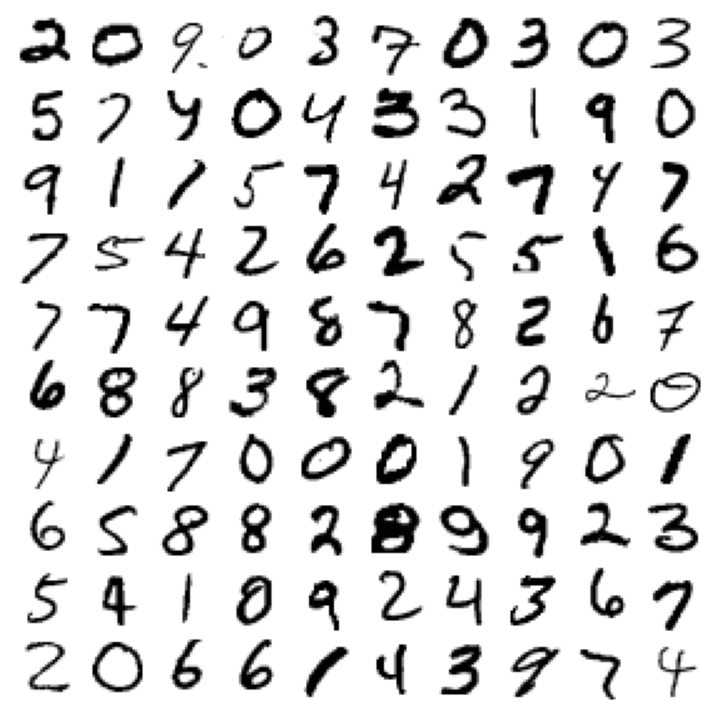

In [14]:
plt.figure(figsize=(9,9))
for i, image_data in enumerate(test_data[:100]):
    plt.subplot(10, 10, i+1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Reshape and normalize data

We need to reshape numpy array of the data to have the next shape - (batch_size, image_rows, image_cols, color_bytes).

**color_bytes** dimension represents RGB color. Black/white in our case.
So, for the current dataset it should be (42000, 28, 28, 1)

In [15]:
def reshape_and_normalize(data):
    data = np.reshape(data, (data.shape[0], 28, 28, 1))
    data = np.divide(data, 255)
    
    return data

In [16]:
# transform test dataset
test_data = reshape_and_normalize(test_data)
print(f'Shape of the test features: {test_data.shape}')

Shape of the test features: (28000, 28, 28, 1)


## Split train dataset into train and validation

In [17]:
VALIDATION_SIZE = 0.1

In [18]:
X_train, X_val, y_train, y_val = train_test_split(train_data, train_data_labels, test_size=VALIDATION_SIZE, random_state=42)

print(f'Train data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')

Train data shape: (37800, 784)
Validation data shape: (4200, 784)


## Image Data Generators

In [19]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels, classes_num):
    training_images = np.reshape(training_images, (training_images.shape[0], 28, 28, 1))
    validation_images = np.reshape(validation_images, (validation_images.shape[0], 28, 28, 1))

    # train data generator
    train_datagen = ImageDataGenerator(rescale=1/255,
                                       rotation_range=10,
                                       zoom_range=0.1,
                                       width_shift_range=0.1,
                                       height_shift_range=0.1)

    train_labels_cat = to_categorical(training_labels, classes_num)
    train_generator = train_datagen.flow(x=training_images,
                                       y=train_labels_cat,
                                       batch_size=128)
    
    # validation data generator
    validation_datagen = ImageDataGenerator(rescale=1/255)
    validation_labels_cat = to_categorical(validation_labels, classes_num)
    validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels_cat,
                                                 batch_size=128)

    return train_generator, validation_generator

In [20]:
#generators
train_generator, validation_generator = train_val_generators(X_train, y_train, X_val, y_val, 10)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (37800, 28, 28, 1)
Labels of training generator have shape: (37800, 10)
Images of validation generator have shape: (4200, 28, 28, 1)
Labels of validation generator have shape: (4200, 10)


# Model Training

In [21]:
def plot_model_history(history):
    # Plot the chart for accuracy and loss on both training and validation
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [44]:
def create_model():
    model = Sequential()
    model.add(Conv2D(64, (5,5), input_shape=(28,28,1), activation='relu', padding='same')),
    model.add(BatchNormalization()),
    
    model.add(Conv2D(64, (5,5), activation='relu')),
    model.add(BatchNormalization()),
    model.add(MaxPooling2D(2,2)),
    model.add(Dropout(0.1)),
    
    model.add(Conv2D(64, (3,3), input_shape=(28,28,1), activation='relu')),
    model.add(BatchNormalization()),
    
    model.add(Conv2D(64, (3,3), input_shape=(28,28,1), activation='relu')),
    model.add(BatchNormalization()),
    model.add(MaxPooling2D(2,2)),
    model.add(Dropout(0.1)),
    
    model.add(Flatten()),
    model.add(Dense(256, activation="relu")),
    model.add(Dropout(0.1)),
    
    model.add(Dense(10, activation="softmax"))
    
    model.compile(optimizer=Adam(learning_rate=1e-3),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

    return model

In [36]:
model = create_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization_10 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 64)        102464    
                                                                 
 batch_normalization_11 (Bat  (None, 24, 24, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                      

In [37]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=30)

Epoch 1/30
296/296 [==============================] - 267s 898ms/step - loss: 0.3846 - accuracy: 0.8825 - val_loss: 4.0937 - val_accuracy: 0.1200
Epoch 2/30
296/296 [==============================] - 274s 927ms/step - loss: 0.1105 - accuracy: 0.9657 - val_loss: 0.0363 - val_accuracy: 0.9867
Epoch 3/30
296/296 [==============================] - 268s 907ms/step - loss: 0.0839 - accuracy: 0.9752 - val_loss: 0.0340 - val_accuracy: 0.9900
Epoch 4/30
296/296 [==============================] - 271s 917ms/step - loss: 0.0703 - accuracy: 0.9786 - val_loss: 0.0279 - val_accuracy: 0.9907
Epoch 5/30
296/296 [==============================] - 267s 903ms/step - loss: 0.0588 - accuracy: 0.9821 - val_loss: 0.0318 - val_accuracy: 0.9910
Epoch 6/30
296/296 [==============================] - 266s 897ms/step - loss: 0.0536 - accuracy: 0.9840 - val_loss: 0.0327 - val_accuracy: 0.9898
Epoch 7/30
296/296 [==============================] - 265s 895ms/step - loss: 0.0558 - accuracy: 0.9832 - val_loss: 0.0360 -

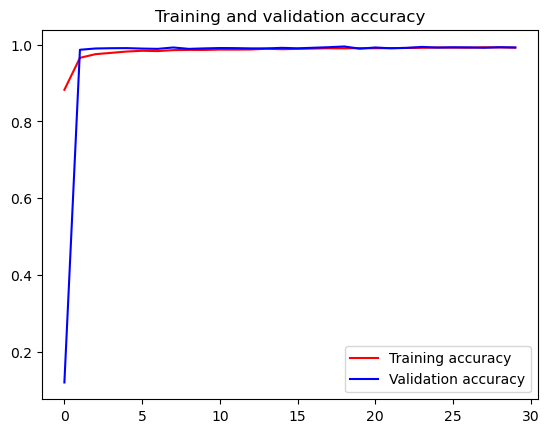

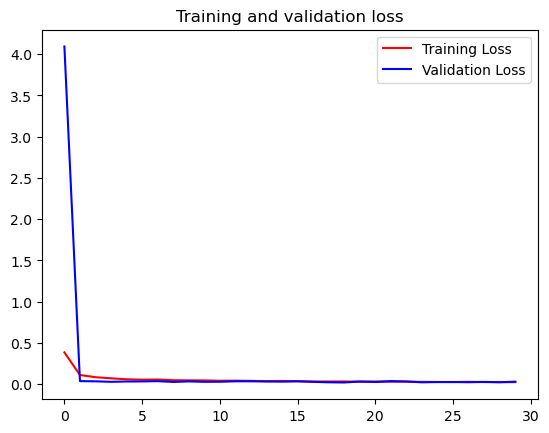

In [38]:
plot_model_history(history)

# Test data predictions

In [39]:
test_data[0].shape
zero_test = test_data[0]
zero_test =np.expand_dims(zero_test, axis=0)
zero_test.shape

(1, 28, 28, 1)

In [40]:
prob = model.predict(zero_test)
np.argmax(prob)

1/1 [==============================] - 0s 202ms/step


2

In [41]:
probabilities = model.predict(test_data)
predictions = np.argmax(probabilities, axis=1)
ids = np.arange(1, len(predictions) + 1)

875/875 [==============================] - 44s 51ms/step


In [42]:
output = pd.DataFrame({'ImageId': ids, 'Label': predictions})
output

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [ ]:
output.to_csv('submission.csv', index=False)

## Save the model

In [43]:
model.save("my_model.keras")